In [1161]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from mpltools import style
from mpltools import layout
style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
from IPython.display import Image
from sklearn import cross_validation
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import cross_validation
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn import svm
from sklearn.naive_bayes import *
from sknn import mlp
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from scipy.stats import ttest_ind

First let's import the Sonar dataset

In [1162]:
data = pd.read_csv("sonar/sonar.all-data", header=None)

Now we divide the dataset into features and labels

In [1163]:
n_cols = len(data.columns)
columns = range(0, n_cols-1)
X = data[columns].values
y = data[n_cols-1].values
y = np.array(map(lambda x: 0 if x == 'M' else 1, y))
labels = [0, 1]
sonar = (X, y, labels)

Let's try to build a Decesion Tree on the whole dataset

In [1164]:
clf = DecisionTreeClassifier()
clf = clf.fit(X, y)

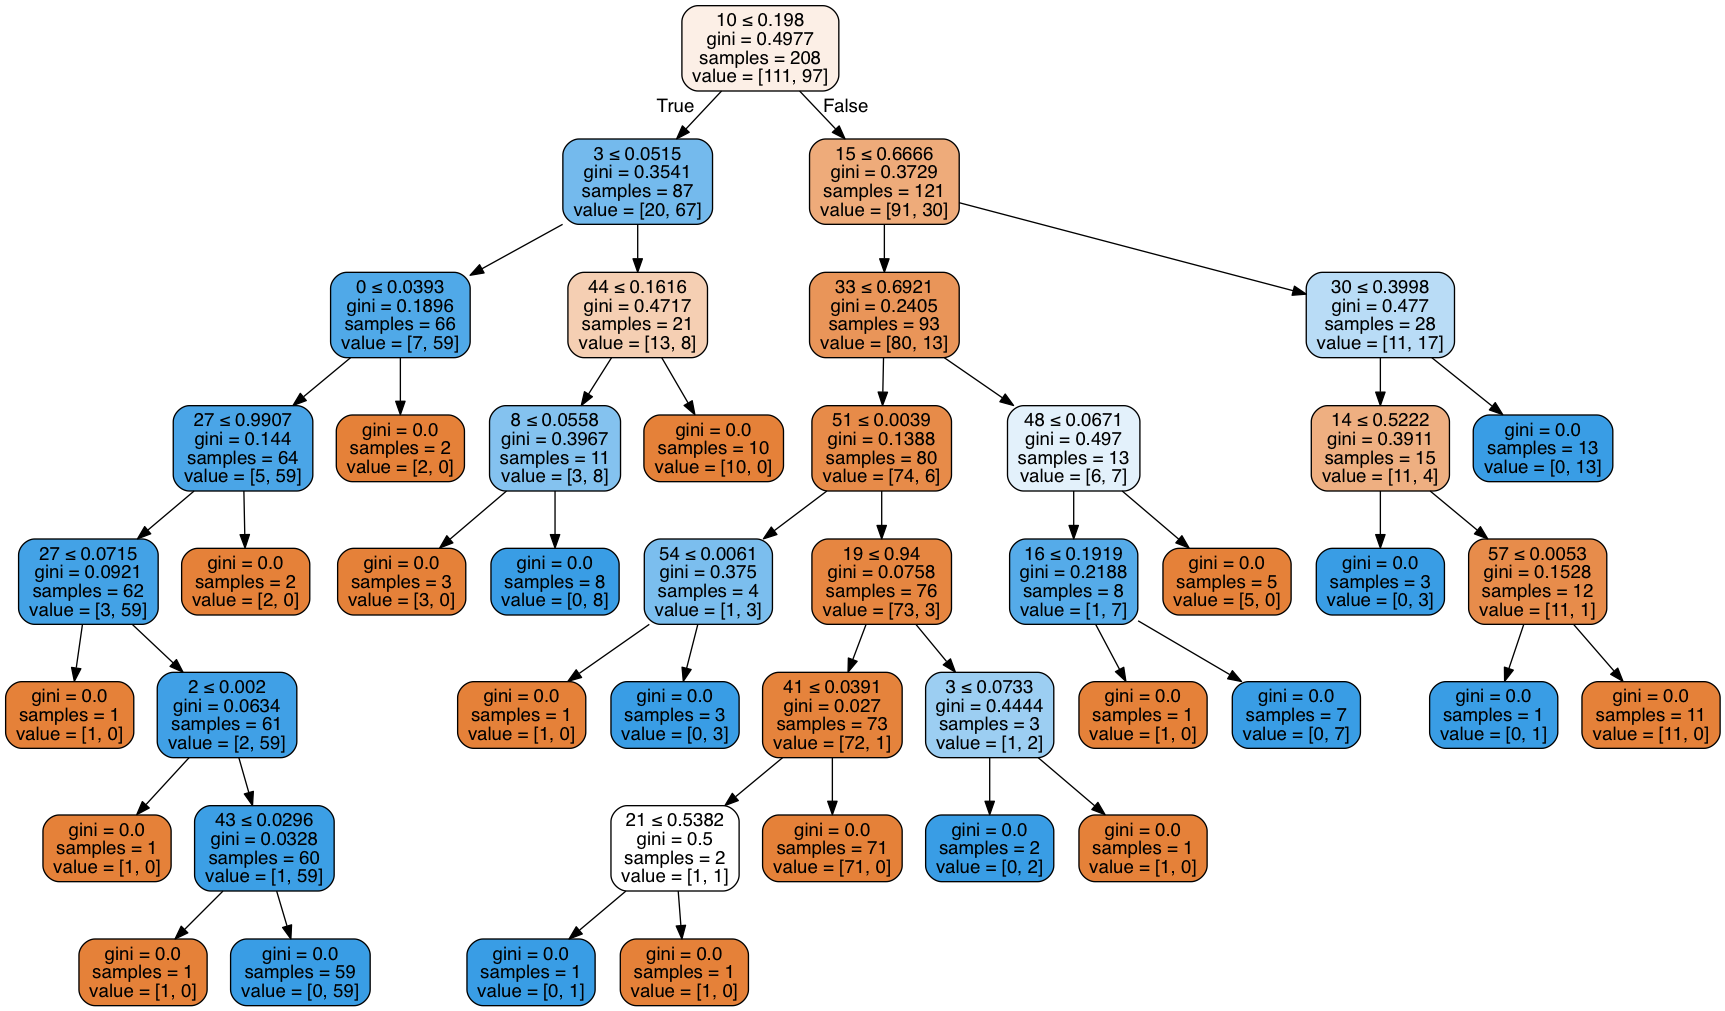

In [1165]:
tree.export_graphviz(clf, out_file="tree.dot",  
                         feature_names=data.columns,    
                         filled=True, rounded=True,  
                         special_characters=True)
!dot -Tpng tree.dot -o tree.png
Image("tree.png")

Let's investigate what would happen if we tested on the whole dataset again

In [1166]:
y_pred = clf.predict(X)
print classification_report(y, y_pred)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00       111
          1       1.00      1.00      1.00        97

avg / total       1.00      1.00      1.00       208



As expected we get 100% accuracy, but this is meaningless because the decision tree just memorized the training data.

We can try to smoothen the tree to generalize on unseen dataset.

In [1167]:
clf = DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, y)
y_pred = clf.predict(X)

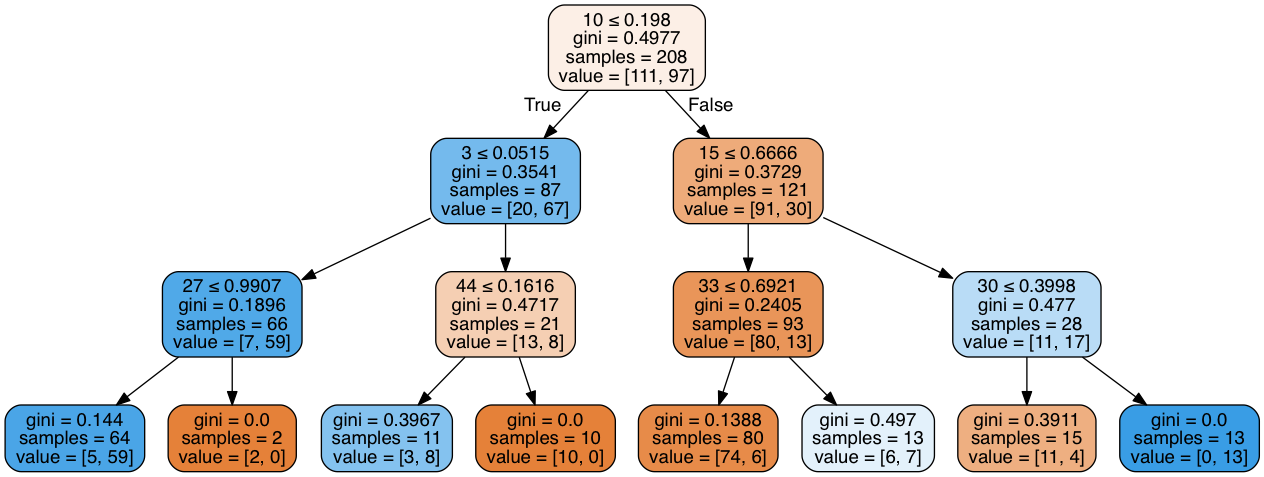

In [1168]:
tree.export_graphviz(clf, out_file="tree.dot",  
                         feature_names=data.columns,    
                         filled=True, rounded=True,  
                         special_characters=True)
!dot -Tpng tree.dot -o tree.png
Image("tree.png")

In [1169]:
print classification_report(y, y_pred)

             precision    recall  f1-score   support

          0       0.91      0.87      0.89       111
          1       0.86      0.90      0.88        97

avg / total       0.89      0.88      0.88       208



The tree can now slightly generalize, But we still cannot evaluate the result because we train on the whole dataset.

Let's divide the data into training/validation using 10-fold Cross Validation

In [1170]:
def get_cross_validation_scores(clf, X, y, n_folds=10, labels=['M', 'R']):
    scores = ['precision', 'recall', 'f-score', 'support']
    cross_validation_scores = np.zeros((len(labels) + 1, len(scores), n_folds))
    i = 0
    for train, test in StratifiedKFold(y, n_folds=n_folds):
        clf = clf.fit(X[train], y[train])
        y_pred = clf.predict(X[test])
        sc = precision_recall_fscore_support(y[test], y_pred, labels=labels)
        tsc = precision_recall_fscore_support(y[test], y_pred)
        for s in range(len(scores)):
            for l in range(len(labels) + 1):
                if (l == len(labels)):
                    continue
                cross_validation_scores[l][s][i] = sc[s][l]
        cross_validation_scores[len(labels)][0][i] = precision_score(y[test], y_pred)
        cross_validation_scores[len(labels)][1][i] = recall_score(y[test], y_pred)
        cross_validation_scores[len(labels)][2][i] = f1_score(y[test], y_pred)
        i += 1
        
    return cross_validation_scores


In [1171]:
def mean(x): return "%.5f" % (sum(x) / len(x))
def cross_validation_report(cv, labels):
    row_format ="{:>15}" * (len(scores) + 1)
    print row_format.format("", *scores)
    for l in range(len(labels)):
        print row_format.format(labels[l], *map(mean, cv[l]))
    cv_tr = np.zeros((len(scores)))
    for s in range(len(scores)):
        cv_tr[s] = 0.0
        for l in range(len(labels)): cv_tr[s] += float(map(mean, cv[l])[s])
    cv_tr = map(lambda x: x / len(labels), cv_tr)
    print row_format.format("total/av", *cv_tr)

Construct the Learning Curve plotting function

In [1172]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

Now let's see who the Decision Tree would perform in the 10-folds setups

In [1173]:
cv = get_cross_validation_scores(DecisionTreeClassifier(), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.67267        0.63864        0.63935       11.10000
              1        0.59605        0.60333        0.58718        9.70000
       total/av        0.63436       0.620985       0.613265           10.4


Now we can see that the DT performs badly. This could be because of the samll number of example which makes the DT unable to generalie

In [1174]:
len(X)

208

Let's try RandomForest

In [1175]:
cv = get_cross_validation_scores(RandomForestClassifier(n_estimators=10), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.69338        0.71439        0.69643       11.10000
              1        0.61849        0.59667        0.59638        9.70000
       total/av       0.655935        0.65553       0.646405           10.4


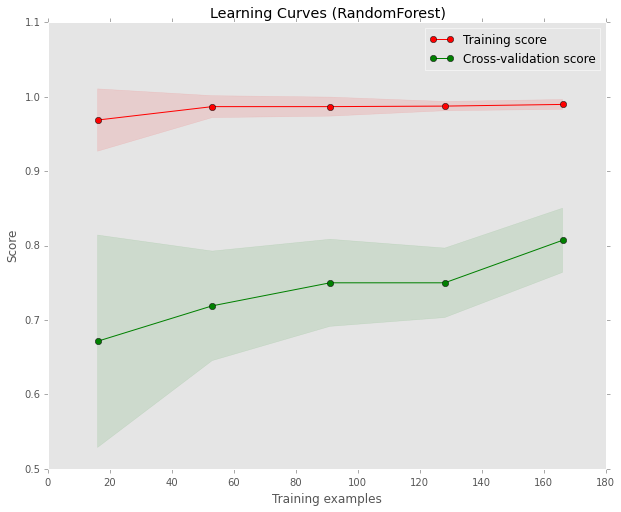

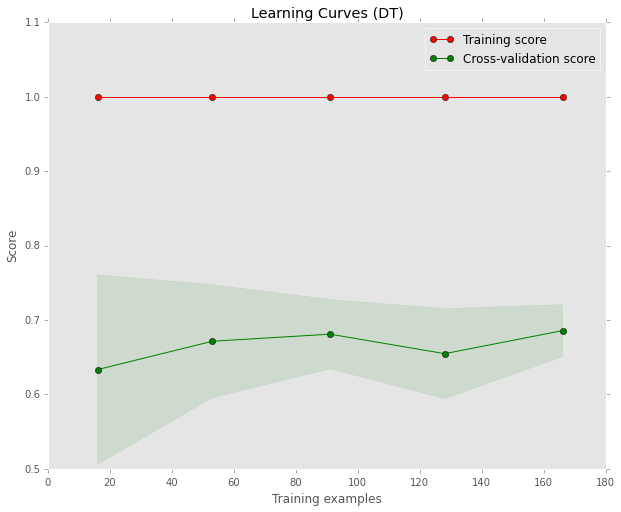

In [1176]:

title = "Learning Curves (RandomForest)"
cv = cross_validation.ShuffleSplit(len(X), n_iter=10,
                                   test_size=0.2, random_state=0)

estimator = RandomForestClassifier(n_estimators=10)
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

title = "Learning Curves (DT)"
cv = cross_validation.ShuffleSplit(len(X), n_iter=10,
                                   test_size=0.2, random_state=0)
estimator = DecisionTreeClassifier()
plot_learning_curve(estimator, title, X, y, cv=cv, n_jobs=4)

plt.show()

As we can see, both DT and RF tend to overfit. But random forest looks like it will perform better on larger dataset as the validation curve is increanig.

Now we have a look an instance of SVM classifier

In [1177]:
cv = get_cross_validation_scores(svm.SVC(kernel='rbf'),X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.56270        0.83788        0.66759       11.10000
              1        0.60657        0.26222        0.33977        9.70000
       total/av       0.584635        0.55005        0.50368           10.4


NaiveBayes with posterior = Bernolli Distribution

In [1178]:
cv = get_cross_validation_scores(BernoulliNB(),X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.53673        1.00000        0.69836       11.10000
              1        0.10000        0.01111        0.02000        9.70000
       total/av       0.318365       0.505555        0.35918           10.4


NaiveBayes with posterior = Bernolli Distribution

In [1179]:
cv = get_cross_validation_scores(GaussianNB(),X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.69727        0.49394        0.54325       11.10000
              1        0.57467        0.72889        0.63013        9.70000
       total/av        0.63597       0.611415        0.58669           10.4


3 Layer Neural Network.

In [1180]:
clf = mlp.Classifier(
    layers=[
        Layer("Linear", units=60),
        Layer("Rectifier", units=30),
        Layer("Softmax")],
    learning_rate=0.02,
    n_iter=10)
cv = get_cross_validation_scores(clf,X, y, labels=labels)
cross_validation_report(cv, labels)

[(22, 2)]
[(21, 2)]
[(21, 2)]
[(21, 2)]
[(21, 2)]
[(21, 2)]
[(21, 2)]
[(20, 2)]
[(20, 2)]
[(20, 2)]
                     precision         recall         fscore        support
              0        0.83593        0.79773        0.80830       11.10000
              1        0.80762        0.83000        0.81131        9.70000
       total/av       0.821775       0.813865       0.809805           10.4


Neural Network performs well than most of the other classifiers.

[(42, 2)]
[(42, 2)]
[(42, 2)]
[(42, 2)]
[(16, 2)]
[(53, 2)]
[(91, 2)]
[(128, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(166, 2)]
[(16, 2)]
[(53, 2)]
[(91, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(16, 2)]
[(128, 2)]
[(166, 2)]
[(53, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(128, 2)]
[(91, 2)]
[(16, 2)]
[(166, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(128, 2)]
[(53, 2)]
[(91, 2)]
[(166, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(91, 2)]
[(16, 2)]
[(53, 2)]
[(128, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(53, 2)]
[(166, 2)]
[(16, 2)]
[(91, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(16, 2)]
[(128, 2)]
[(166, 2)]
[(53, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(128, 2)]
[(91, 2)]
[(166, 2)]
[(16, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(91, 2)]
[(53, 2)]
[(128, 2)]
[(166, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(53, 2)]
[(16, 2)]
[(91, 2)]
[(128, 2)]
[(42, 2)][(42, 2)][(42, 2)][(42, 2)]



[(16, 2)]
[(166, 2)]
[(53, 2)]
[(91, 2)]
[(42, 2)][(42, 2)]

[(

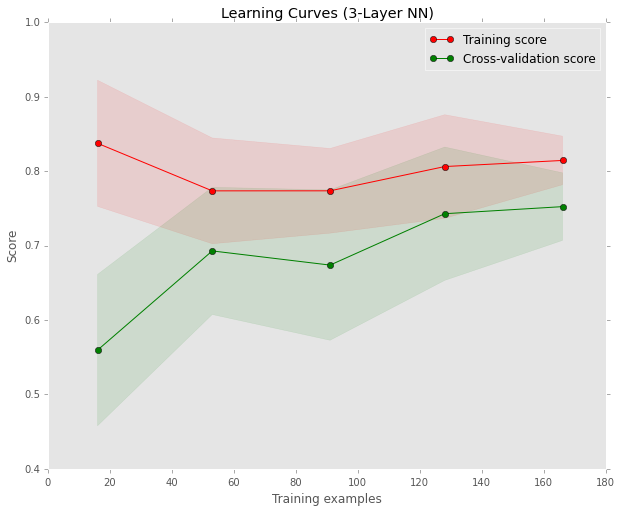

In [1181]:

title = "Learning Curves (3-Layer NN)"
cv = cross_validation.ShuffleSplit(len(X), n_iter=10,
                                   test_size=0.2, random_state=0)

plot_learning_curve(clf, title, X, y, cv=cv, n_jobs=4)


plt.show()

NeuralNetwork overfits. However, with smoothing the paramters it might perform better results than RandomForest.

Now let's try an instance of the Ensumble learning methods (Bagging) with DT as the base estimator 

In [1182]:
cv = get_cross_validation_scores(BaggingClassifier(DecisionTreeClassifier(), n_estimators=15), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.69220        0.70682        0.68189       11.10000
              1        0.69547        0.61667        0.62873        9.70000
       total/av       0.693835       0.661745        0.65531           10.4


AdaBoost with DT as the base estimator

In [1183]:
cv = get_cross_validation_scores(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=15), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.64720        0.58485        0.59786       11.10000
              1        0.56890        0.60333        0.57286        9.70000
       total/av        0.60805        0.59409        0.58536           10.4


### Part4

Let's import the hepatitis dataset

In [1184]:
hepatitis = pd.read_csv("hepatitis/hepatitis.data", header=None)

In [1185]:
for c in hepatitis.columns:
    hepatitis[c] = pd.to_numeric(hepatitis[c], errors='coerce')
    hepatitis[c] = hepatitis[c].fillna(hepatitis[c][pd.notnull(hepatitis[c])].median())

In [1186]:
n_cols = len(hepatitis.columns)
columns = range(1, n_cols)
X = hepatitis[columns].values
y = hepatitis[0].values
labels = list(set(y))
hept = (X, y, labels)

In [1187]:
cv = get_cross_validation_scores(BaggingClassifier(DecisionTreeClassifier(), n_estimators=15), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              1        0.55357        0.49167        0.46730        3.20000
              2        0.87258        0.87628        0.86635       12.30000
       total/av       0.713075       0.683975       0.666825           7.75


PIMA dataset

In [1188]:
pima = pd.read_csv("pima/pima-indians-diabetes.data", header=None)

In [1189]:
for c in hepatitis.columns[1:7]:
    pima[c] = pima[c].replace(0, pima[c][pima[c] > 0].median())

In [1190]:
n_cols = len(pima.columns)
columns = range(0, n_cols-1)
X = pima[columns].values
y = pima[n_cols-1].values
labels = list(set(y))
pim = (X, y, labels)

In [1191]:
cv = get_cross_validation_scores(BaggingClassifier(DecisionTreeClassifier(), n_estimators=15), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.79118        0.82600        0.80663       50.00000
              1        0.65391        0.58960        0.61423       26.80000
       total/av       0.722545         0.7078        0.71043           38.4


SPECT dataset

In [1192]:
spect_train = pd.read_csv("spect/SPECT.train", header=None)
spect_test = pd.read_csv("spect/SPECT.test", header=None)
spect = spect_train.append(spect_test)

In [1193]:
n_cols = len(spect.columns)
columns = range(1, n_cols)
X = spect[columns].values
y = spect[0].values
labels = list(set(y))
spec = (X, y, labels)

In [1194]:
cv = get_cross_validation_scores(BaggingClassifier(DecisionTreeClassifier(), n_estimators=15), X, y, labels=labels)
cross_validation_report(cv, labels)

                     precision         recall         fscore        support
              0        0.63323        0.50333        0.52962        5.50000
              1        0.87806        0.90108        0.88573       21.20000
       total/av       0.755645       0.702205       0.707675          13.35


Not let's draw some comparisons on the datasets vs algorithsm

In [1195]:
algorithms = {
             "DecisionTree": DecisionTreeClassifier(),
             "RandomForest-10": RandomForestClassifier(n_estimators=10),
             "NaiveBayes-Gaussian": GaussianNB(),
             "AdaBoost-DT-15": AdaBoostClassifier(DecisionTreeClassifier(), n_estimators=15),
             "Bagging-DT": BaggingClassifier(DecisionTreeClassifier(), n_estimators=15),
             "NaiveBayes-BN": GaussianNB()
             }

datasets = {"sonar": sonar,
            "pima": pim,
            "hepatitis": hept,
            "SPECT": spec}

The Avarage Percision Score for each Dataset X Algorithm 

In [1196]:
matrix_precision = pd.DataFrame(index=datasets.keys(), columns=algorithms.keys())
for ds in datasets.keys():
    for algo in algorithms.keys():
        matrix_precision.loc[ds, algo] = get_cross_validation_scores(algorithms[algo], datasets[ds][0], datasets[ds][1], labels=datasets[ds][2])[-1][0].mean()
matrix_precision

,AdaBoost-DT-15,NaiveBayes-BN,DecisionTree,Bagging-DT,RandomForest-10,NaiveBayes-Gaussian
sonar,0.591423,0.574669,0.5925,0.715963,0.737406,0.574669
SPECT,0.862904,0.964524,0.877293,0.875277,0.878997,0.964524
hepatitis,0.534524,0.564762,0.5525,0.66,0.692857,0.564762
pima,0.547203,0.655004,0.562485,0.638274,0.687052,0.655004


The Avarage Recall Score for each Dataset X Algorithm

In [1197]:
matrix_recall = pd.DataFrame(index=algorithms.keys(), columns=datasets.keys())
for ds in datasets.keys():
    for algo in algorithms.keys():
        matrix_recall.loc[algo, ds] = get_cross_validation_scores(algorithms[algo], datasets[ds][0], datasets[ds][1], labels=datasets[ds][2])[-1][1].mean()
matrix_recall

,sonar,SPECT,hepatitis,pima
AdaBoost-DT-15,0.573333,0.862987,0.525,0.552137
NaiveBayes-BN,0.728889,0.472511,0.741667,0.604274
DecisionTree,0.592222,0.806494,0.525,0.564103
Bagging-DT,0.626667,0.900649,0.491667,0.611681
RandomForest-10,0.68,0.905411,0.483333,0.522507
NaiveBayes-Gaussian,0.728889,0.472511,0.741667,0.604274


The Avarage F1 Score for each Dataset X Algorithm

In [ ]:
matrix_f1 = pd.DataFrame(index=algorithms.keys(), columns=datasets.keys())
for ds in datasets.keys():
    for algo in algorithms.keys():
        matrix_f1.loc[algo, ds] = get_cross_validation_scores(algorithms[algo], datasets[ds][0], datasets[ds][1], labels=datasets[ds][2])[-1][2].mean()
matrix_f1

,sonar,SPECT,hepatitis,pima
AdaBoost-DT-15,0.565006,0.865666,0.469444,0.564089
NaiveBayes-BN,0.630129,0.61544,0.571587,0.626263
DecisionTree,0.576349,0.834318,0.446212,0.569402
Bagging-DT,0.624075,0.863878,0.299697,0.641539
RandomForest-10,0.626118,0.887698,0.563492,0.599265
NaiveBayes-Gaussian,0.630129,0.61544,0.571587,0.626263


Now let's see the statistical significance between each two algorithms on the Sonar dataset

P-Values

In [ ]:
ds = "sonar"
matrix_f1 = pd.DataFrame(index=algorithms.keys(), columns=algorithms.keys())
for algo1 in algorithms.keys():
    for algo2 in algorithms.keys():
        res1 = []
        res2 = []
        for i in range(10):
            res1.append(get_cross_validation_scores(algorithms[algo1], datasets[ds][0], datasets[ds][1], labels=datasets[ds][2])[-1][2].mean())
            res2.append(get_cross_validation_scores(algorithms[algo2], datasets[ds][0], datasets[ds][1], labels=datasets[ds][2])[-1][2].mean())
        matrix_f1.loc[algo1, algo2] = ttest_ind(res1, res2)[1]
matrix_f1

T-Statistics

In [ ]:
ds = "sonar"
matrix_f1 = pd.DataFrame(index=algorithms.keys(), columns=algorithms.keys())
for algo1 in algorithms.keys():
    for algo2 in algorithms.keys():
        res1 = []
        res2 = []
        for i in range(10):
            res1.append(get_cross_validation_scores(algorithms[algo1], datasets[ds][0], datasets[ds][1], labels=datasets[ds][2])[-1][2].mean())
            res2.append(get_cross_validation_scores(algorithms[algo2], datasets[ds][0], datasets[ds][1], labels=datasets[ds][2])[-1][2].mean())
        matrix_f1.loc[algo1, algo2] = ttest_ind(res1, res2)[0]
matrix_f1

We can draw some conclusions from both tables:
- RandomForst has significannlly different results than most other classifiers.
- Adaboost has significannlly different results than most other classifiers
- Bernolli NaiveBayes performs badly and we than any other classifier. 